In [1]:
from implementations import *

import numpy as np
import pandas as pd

import zipfile

from scipy.stats import entropy

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go

from sklearn.manifold import TSNE, trustworthiness
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

from transformers import AutoTokenizer, AutoModel
import torch
import umap

# <b><u> Data Loading </u></b> #

We load only the relevant columns since the dataset is already quite large (3 million rows).

In [ ]:
zip_file_path = 'BindingDB_All_202409_tsv.zip'
file_path = 'BindingDB_All.tsv'

list_columns_kept = ['Ligand SMILES', 'Target Name', 'Target Source Organism According to Curator or DataSource', 'Target Name', 'Institution', 'Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)', 'kon (M-1-s-1)', 'koff (s-1)', 'pH', 'Temp (C)', 
                'Number of Protein Chains in Target (>1 implies a multichain complex)', 'BindingDB Target Chain Sequence', 'BindingDB Target Chain Sequence.1',
                'BindingDB Target Chain Sequence.2', 'BindingDB Target Chain Sequence.3', 'BindingDB Target Chain Sequence.4', 'BindingDB Target Chain Sequence.5',
                'BindingDB Target Chain Sequence.6', 'BindingDB Target Chain Sequence.7', 'BindingDB Target Chain Sequence.8', 'BindingDB Target Chain Sequence.9', 
                'BindingDB Target Chain Sequence.10', 'BindingDB Target Chain Sequence.11', 'BindingDB Target Chain Sequence.12']


with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open('BindingDB_All.tsv') as file:
        data = pd.read_csv(file, sep='\t', usecols=list_columns_kept, na_values=['', 'NULL'])

data = pd.DataFrame(data)
data.sample()

C:\Users\hudrya\AppData\Local\Temp\ipykernel_2948\2386863531.py:13: DtypeWarning: Columns (8,9,10,11,12,13,15,23,50,62,74,86,98,110,122,134,146,158,170,182) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file, sep='\t', usecols=list_columns_kept, na_values=['', 'NULL'])


Ligand SMILES  \
0  O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=...   
1  O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...   
2  O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...   
3  OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...   
4  OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...   

                              Target Name  \
0  Dimer of Gag-Pol polyprotein [501-599]   
1  Dimer of Gag-Pol polyprotein [501-599]   
2  Dimer of Gag-Pol polyprotein [501-599]   
3  Dimer of Gag-Pol polyprotein [501-599]   
4  Dimer of Gag-Pol polyprotein [501-599]   

  Target Source Organism According to Curator or DataSource Ki (nM) IC50 (nM)  \
0                     Human immunodeficiency virus 1           0.24       NaN   
1                     Human immunodeficiency virus 1           0.25       NaN   
2                     Human immunodeficiency virus 1           0.41       NaN   
3                     Human immunodeficiency virus 1            0.8       NaN   
4                     Human immunodeficiency virus 1           0.99       NaN   

  Kd (nM) EC50 (nM) kon (M-1-s-1) koff (s-1)   pH  ...  \
0     NaN       NaN           NaN        NaN  5.5  ...   
1     NaN       NaN           NaN        NaN  5.5  ...   
2     NaN       NaN           NaN        NaN  5.5  ...   
3     NaN       NaN           NaN        NaN  5.5  ...   
4     NaN       NaN           NaN        NaN  5.5  ...   

  BindingDB Target Chain Sequence.3 BindingDB Target Chain Sequence.4  \
0                               NaN                               NaN   
1                               NaN                               NaN   
2                               NaN                               NaN   
3                               NaN                               NaN   
4                               NaN                               NaN   

   BindingDB Target Chain Sequence.5 BindingDB Target Chain Sequence.6  \
0                                NaN                               NaN   
1                                NaN                               NaN   
2                                NaN                               NaN   
3                                NaN                               NaN   
4                                NaN                               NaN   

  BindingDB Target Chain Sequence.7 BindingDB Target Chain Sequence.8  \
0                               NaN                               NaN   
1                               NaN                               NaN   
2                               NaN                               NaN   
3                               NaN                               NaN   
4                               NaN                               NaN   

  BindingDB Target Chain Sequence.9 BindingDB Target Chain Sequence.10  \
0                               NaN                                NaN   
1                               NaN                                NaN   
2                               NaN                                NaN   
3                               NaN                                NaN   
4                               NaN                                NaN   

  BindingDB Target Chain Sequence.11 BindingDB Target Chain Sequence.12  
0                                NaN                                NaN  
1                                NaN                                NaN  
2                                NaN                                NaN  
3                                NaN                                NaN  
4                                NaN                                NaN  

[5 rows x 26 columns]

# <b><u> Some Insight on Data </u></b> #

First, we check the number of proteins for each organism. Since we will be performing data cleaning, we will focus on organisms with high protein counts.

In [16]:
# Get the value counts in the organism column
col_name = 'Target Source Organism According to Curator or DataSource'
if col_name in data.columns:
    value_counts = data.groupby(col_name).size().sort_values(ascending=False)
print(value_counts[0:10])

Target Source Organism According to Curator or DataSource
Homo sapiens                      1541025
Rattus norvegicus                  109758
Mus musculus                        49854
Rattus                              33718
Human immunodeficiency virus 1      21780
Bos taurus                          17618
Electrophorus electricus             7921
Cavia porcellus                      7639
Cavia cutleri                        6540
Escherichia coli                     5651
dtype: int64


Some viruses, such as HIV-1, have high counts. Here, we compare their counts and identify the institutions that studied them.

total number of virus associated protein: 42342


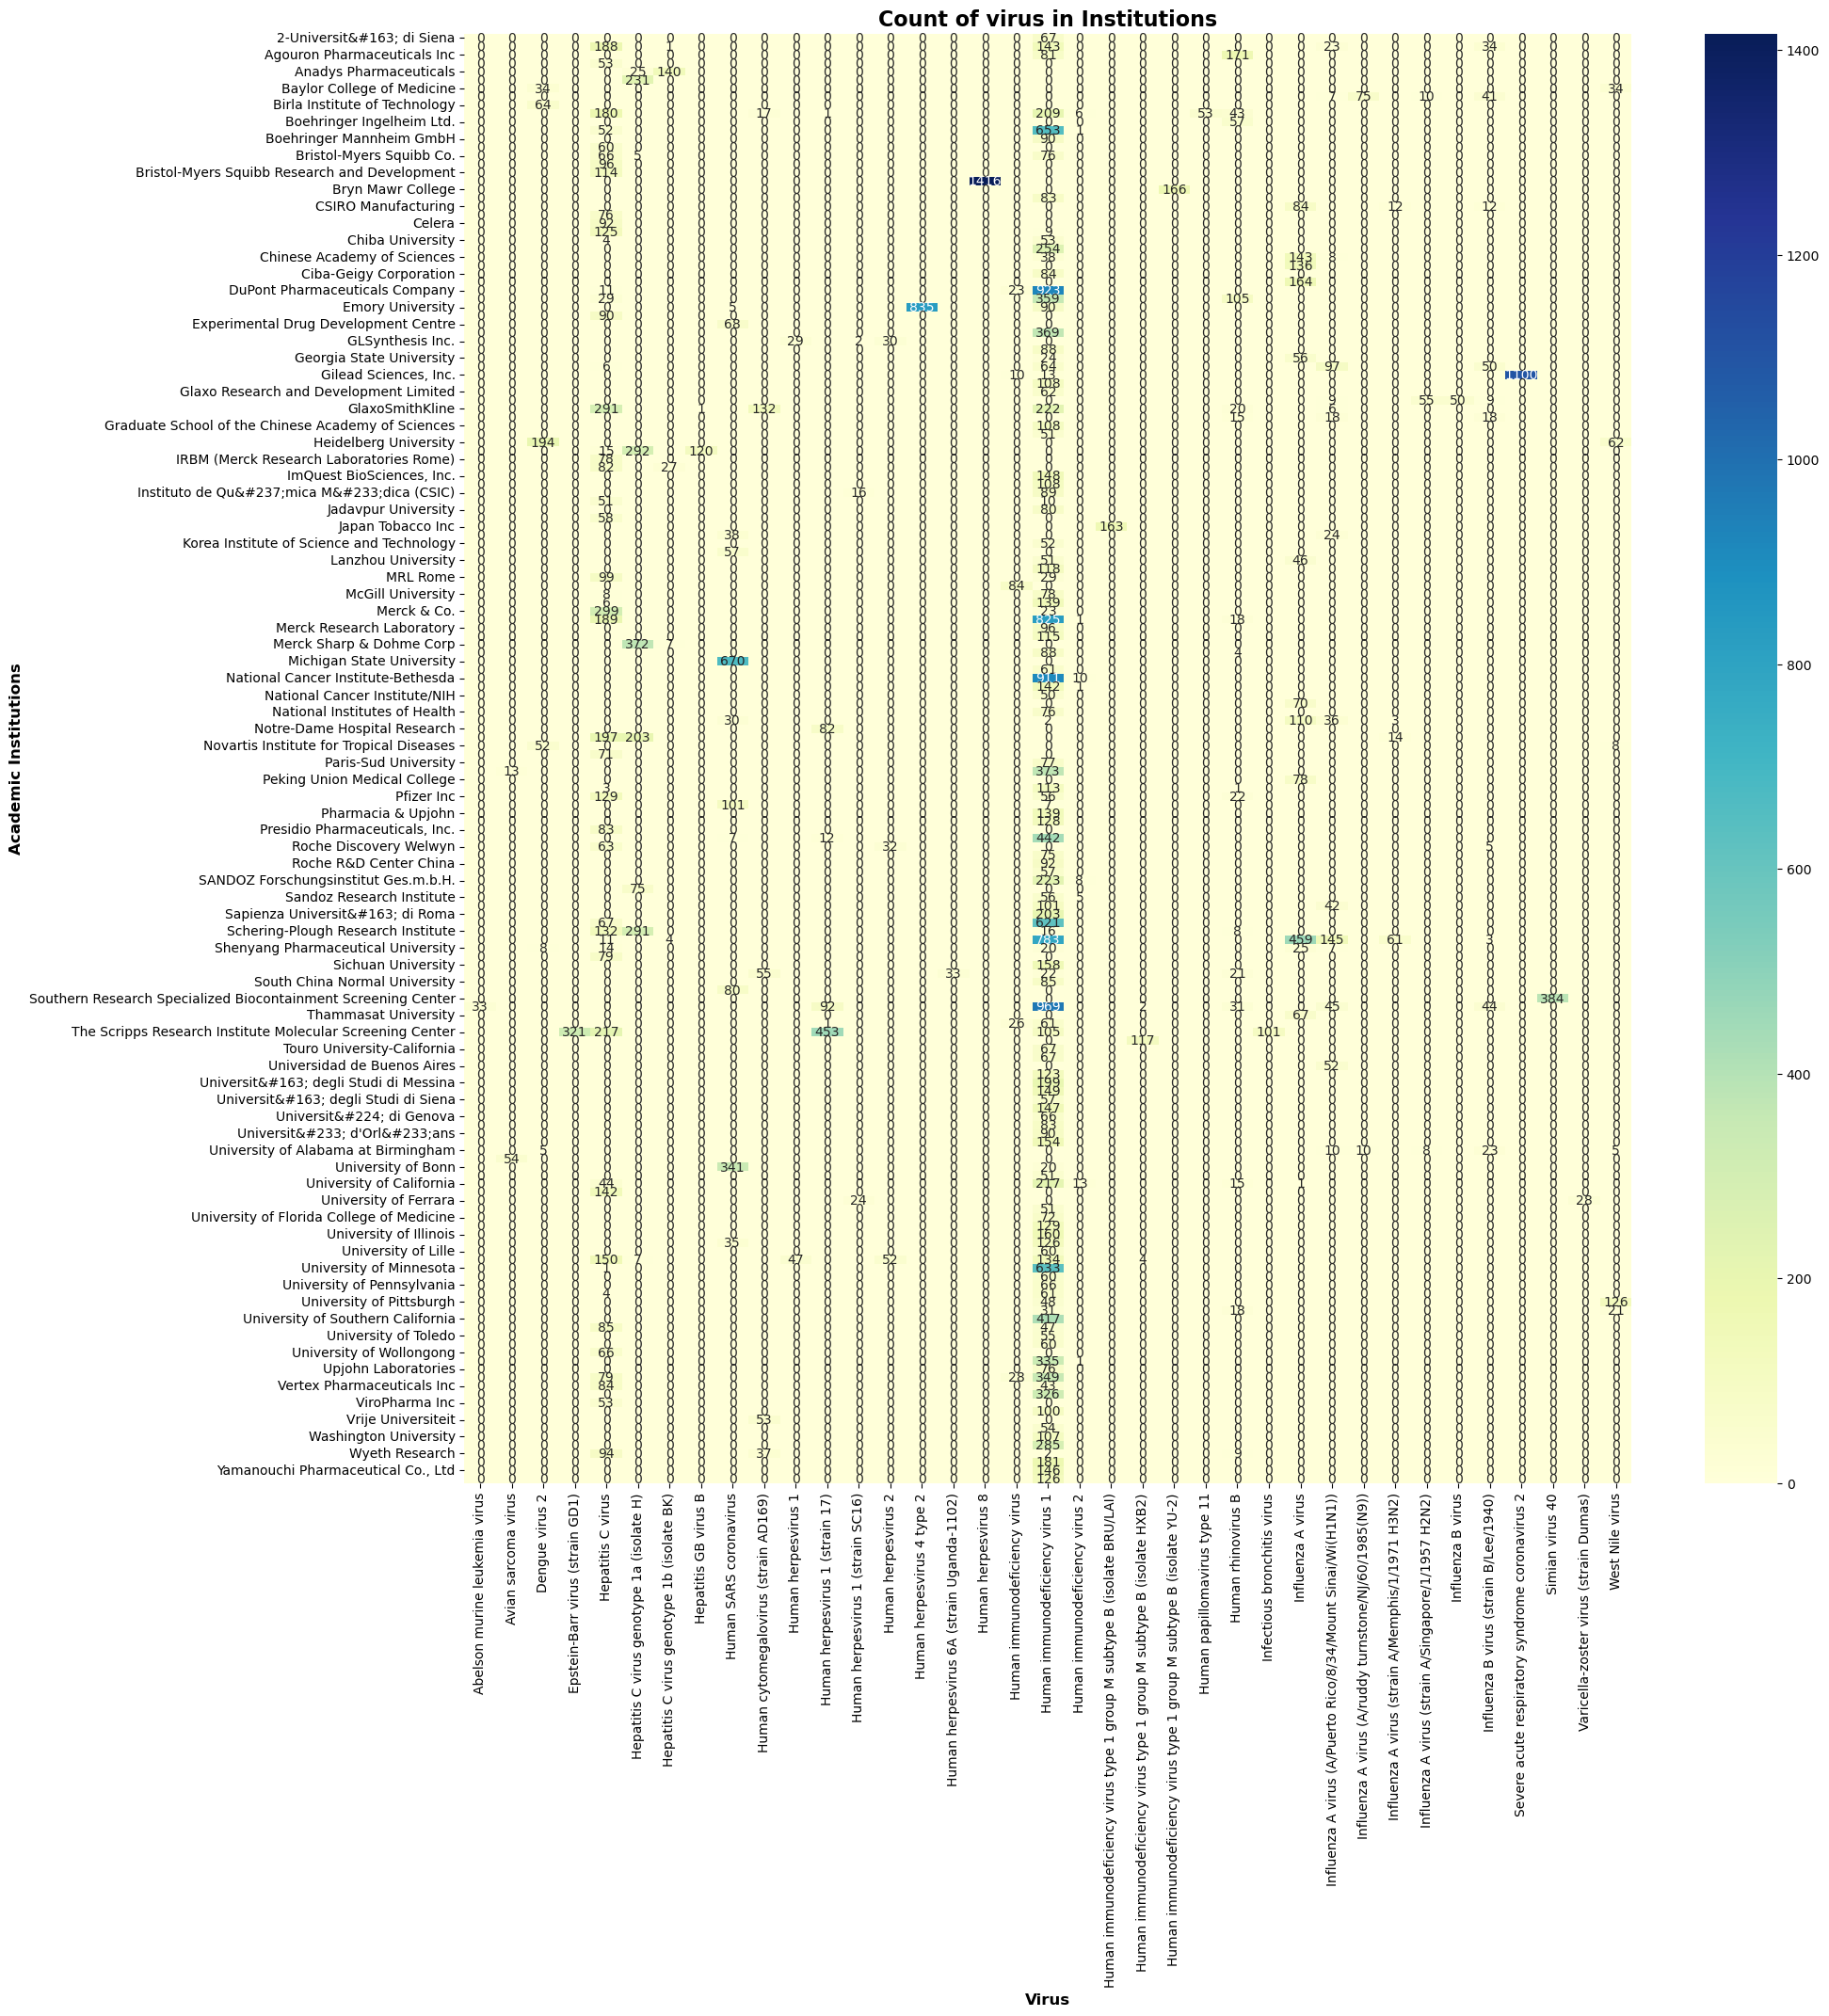

In [23]:
virus_data = data[data['Target Source Organism According to Curator or DataSource'].str.contains('virus', case=False, na=False)]

print(f'total number of virus associated protein: {virus_data["Target Source Organism According to Curator or DataSource"].value_counts().sum()}')

virus_counts = pd.crosstab(virus_data['Institution'], 
                           virus_data['Target Source Organism According to Curator or DataSource'])

virus_counts = virus_counts.loc[:, virus_counts.sum(axis=0) >= 50] 
virus_counts = virus_counts[virus_counts.sum(axis=1) >= 50]

plt.figure(figsize=(20, 20))
sns.heatmap(virus_counts, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Count of virus in Institutions', fontweight=800,fontsize=16)
plt.xlabel('Virus',fontweight=800,fontsize=12)
plt.ylabel('Academic Institutions', fontweight=800,fontsize=12)
plt.show()

Among all viruses, HIV-1 is the only one with sufficient data on Ki. Kd has too low numbers to be exploitable.

In [26]:
non_nan_ki = virus_data['Ki (nM)'].count()
print('Numbers of data containing Ki information (all viruses): ', non_nan_ki)

non_nan_kd = virus_data['Kd (nM)'].count()
print('Numbers of data containing Kd information (all viruses): ', non_nan_kd)

Numbers of data containing Ki information (all viruses):  6415
Numbers of data containing Kd information (all viruses):  406


In [27]:
hiv_data = data[data['Target Source Organism According to Curator or DataSource'] == 'Human immunodeficiency virus 1'].reset_index(drop=True)

non_nan_ki = hiv_data['Ki (nM)'].count()
print('Numbers of data containing Ki information (Hiv1): ', non_nan_ki)

non_nan_kd = hiv_data['Kd (nM)'].count()
print('Numbers of data containing Kd information (Hiv1): ', non_nan_kd)

Numbers of data containing Ki information (Hiv1):  4350
Numbers of data containing Kd information (Hiv1):  237


# <b><u> Focusing on Hiv1 </u></b> #

Some data rows contain Ki values like '<100' or '>30000', which are difficult to interpret. Therefore, we choose to drop these rows.

In [ ]:
# Choosing the metric which is the most present
metric = 'Ki (nM)'

# Filter for Hiv1
hiv_data = data[data['Target Source Organism According to Curator or DataSource'] == 'Human immunodeficiency virus 1'].reset_index(drop=True)
print(f'prior size: {hiv_data.shape[0]}')

mask_invalid_values = hiv_data[metric].str.contains('<',case=False,na=False) | hiv_data[metric].str.contains('>',case=False,na=False) | hiv_data[metric].isna()
print(f'final size: {hiv_data.shape[0] - mask_invalid_values.sum()}')
hiv_data = hiv_data[~mask_invalid_values]

prior size: 21780
final size: 4171


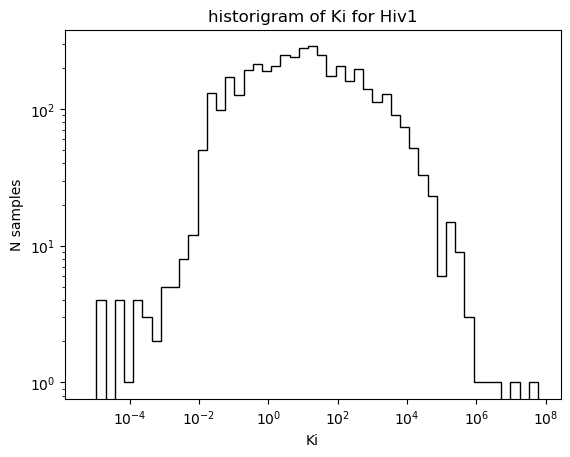

In [ ]:
# Check metric distribution
metric_numeric = pd.to_numeric(hiv_data[metric], errors='coerce').dropna()
bins = np.logspace(np.log10(metric_numeric.min()), np.log10(metric_numeric.max()), 50)
plt.hist(metric_numeric, bins=bins, edgecolor="black", histtype="step", log=True)

plt.xscale('log')
plt.title('historigram of Ki for Hiv1')
plt.xlabel('Ki')
plt.ylabel('N samples')
plt.show()

Number of Ligand compounds in HIV1:  5638


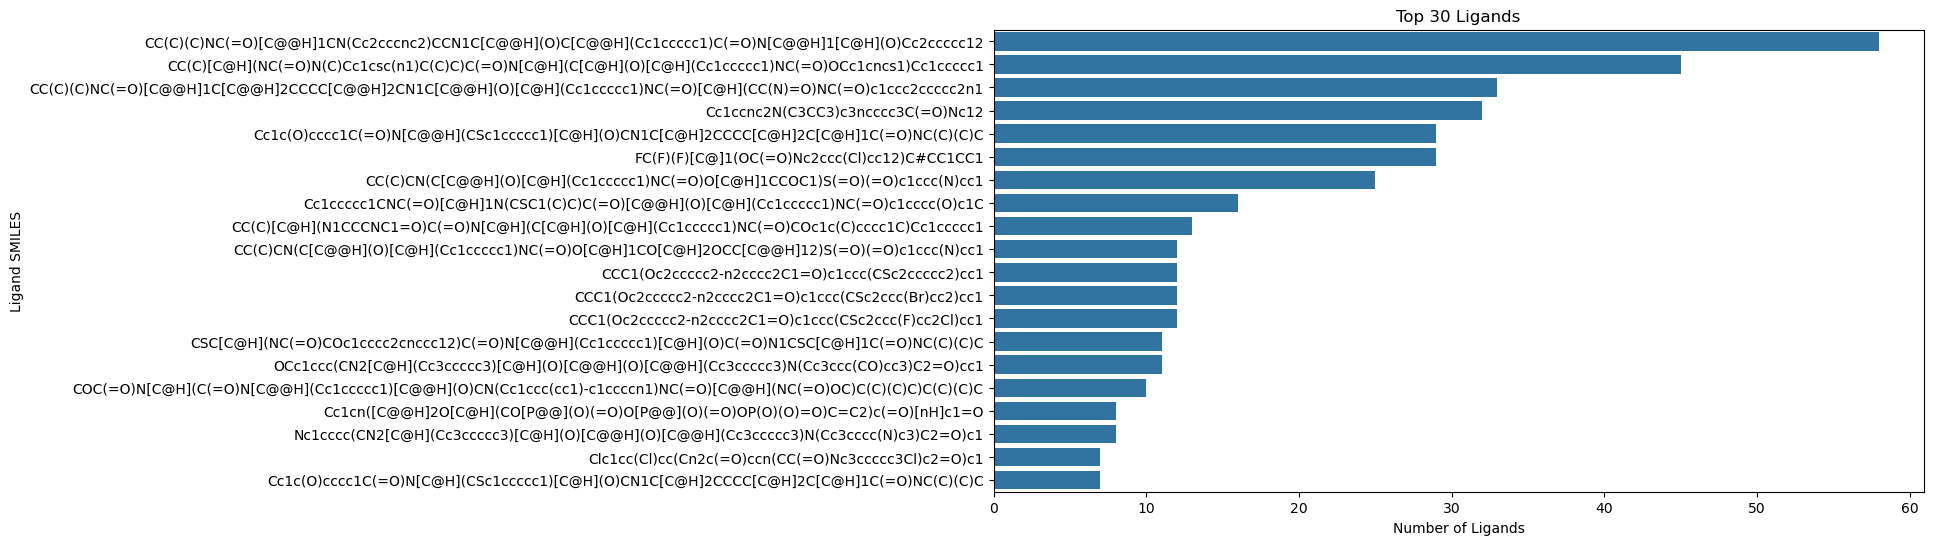

In [ ]:
# Check the Ligand for Hiv1
target_counts = hiv_data.groupby('Ligand SMILES').size().reset_index(name='Compound Count')

target_counts = target_counts.sort_values(by='Compound Count', ascending=False)
print('Number of Ligand compounds in HIV1: ', target_counts.size)

plt.figure(figsize=(12, 6))
sns.barplot(x='Compound Count', y='Ligand SMILES', data=target_counts.head(20))
plt.title('Top 30 Ligands')
plt.xlabel('Number of Ligands')
plt.ylabel('Ligand SMILES')
plt.show()

Number of targets of the compounds in HIV1:  126


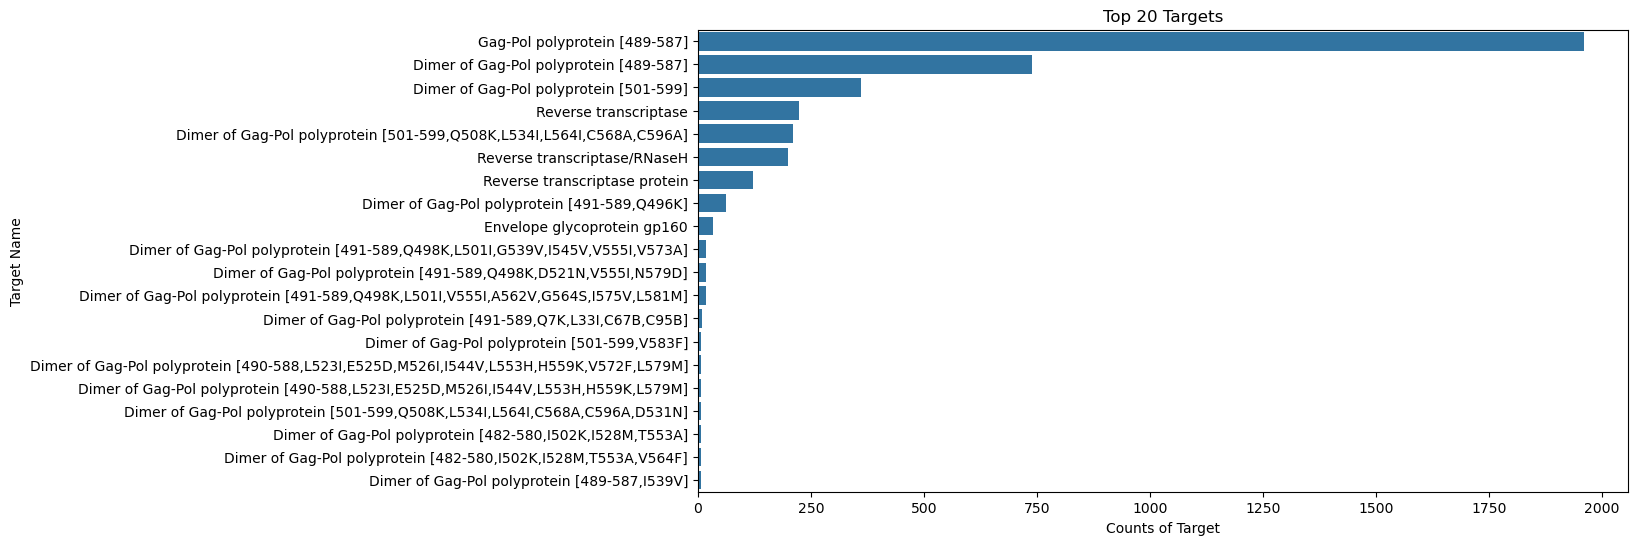

In [ ]:
# Check the targets for Hiv1
target_counts = hiv_data.groupby('Target Name').size().reset_index(name='Compound Count')

target_counts = target_counts.sort_values(by='Compound Count', ascending=False)
print('Number of targets of the compounds in HIV1: ', target_counts.size)

plt.figure(figsize=(12, 6))
sns.barplot(x='Compound Count', y='Target Name', data=target_counts.head(20))
plt.title('Top 20 Targets')
plt.xlabel('Counts of Target')
plt.ylabel('Target Name')
plt.show()

In [ ]:
col_name = 'Number of Protein Chains in Target (>1 implies a multichain complex)'
seq_col = 'BindingDB Target Chain Sequence'

if col_name in hiv_data.columns and seq_col in hiv_data.columns:
    unique_data = hiv_data.drop_duplicates(subset=[seq_col])
    count_Nchain = unique_data[col_name].value_counts()

count_Nchain

Number of Protein Chains in Target (>1 implies a multichain complex)
1    56
2     7
Name: count, dtype: int64

# <u><b>CLUSTERING</b></u>

## <b>Clustering with Morgan Fingerprints: </b> ##

In [ ]:
smiles_list = hiv_data['Ligand SMILES'].unique().tolist()

### Using TSNE: Generate Fingerprints + Compute and Plot Scores ###

Radius = 2
Perplexity = 5
Perplexity = 20
Perplexity = 35
Perplexity = 50
Radius = 3
Perplexity = 5
Perplexity = 20
Perplexity = 35
Perplexity = 50
Radius = 4
Perplexity = 5
Perplexity = 20
Perplexity = 35
Perplexity = 50
Radius = 5
Perplexity = 5
Perplexity = 20
Perplexity = 35
Perplexity = 50


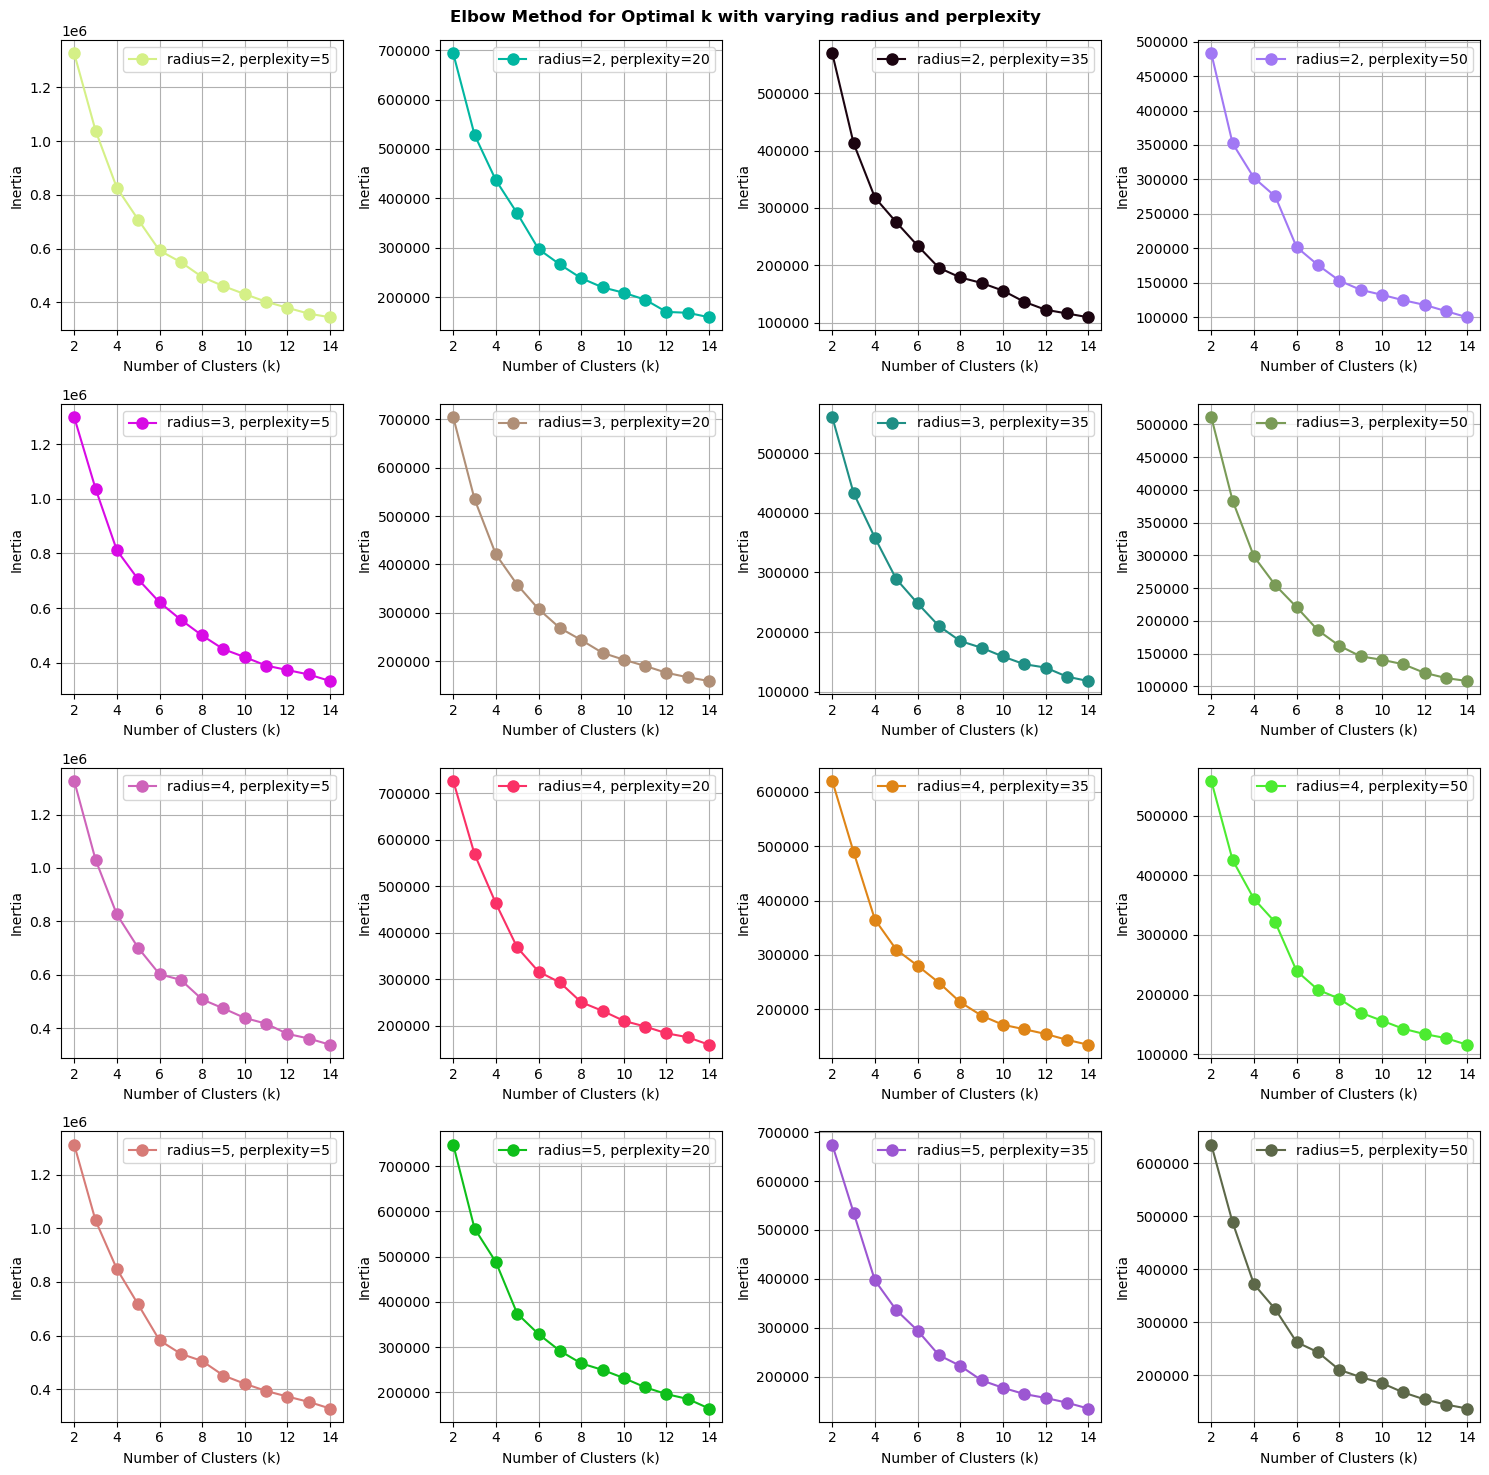

In [ ]:
radiuses = [2,3,4,5]
perplexities = [5,20,35,50]
Ks = range(2, 15)
nrows, ncols = len(radiuses), len(perplexities)

tsn_results, KLs, s_scores = plot_elbow_curve(
    method='tsne',
    original_data=smiles_list,
    param1_list=radiuses,
    param2_list=perplexities,
    Ks=Ks,
    param1_name='radius',
    param2_name='perplexity',
    metric='jaccard'
)

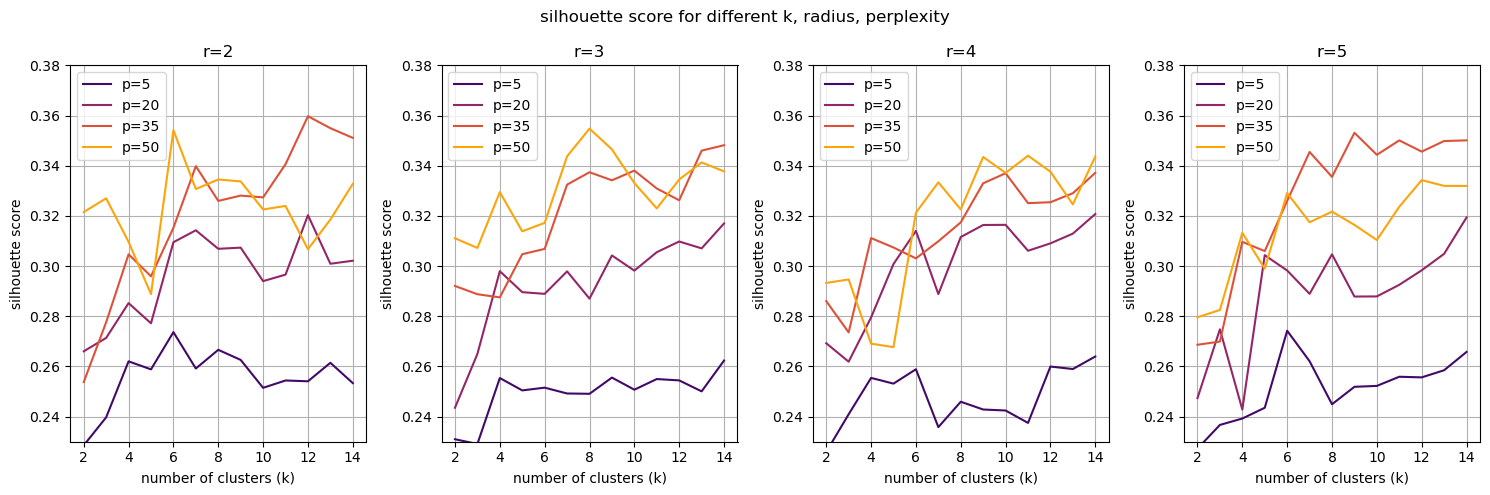

In [ ]:
plot_silhouette_scores(
    s_scores, Ks, radiuses, perplexities, 
    param1_name='r', param2_name='p', y_lim=(0.23, 0.38),
    color_palette="inferno", title="silhouette score for different k, radius, perplexity"
)

### Choosing best clusters from plots + Observing according distributions ###

In [ ]:
# Choose best k for each radius and perplexity based on the graphes (not always clearly defined for some) (above 12 is excessive)
best_ks = [[6,12,12,6],
           [4,9,8,8],
           [6,6,10,9],
           [6,8,12,9]]

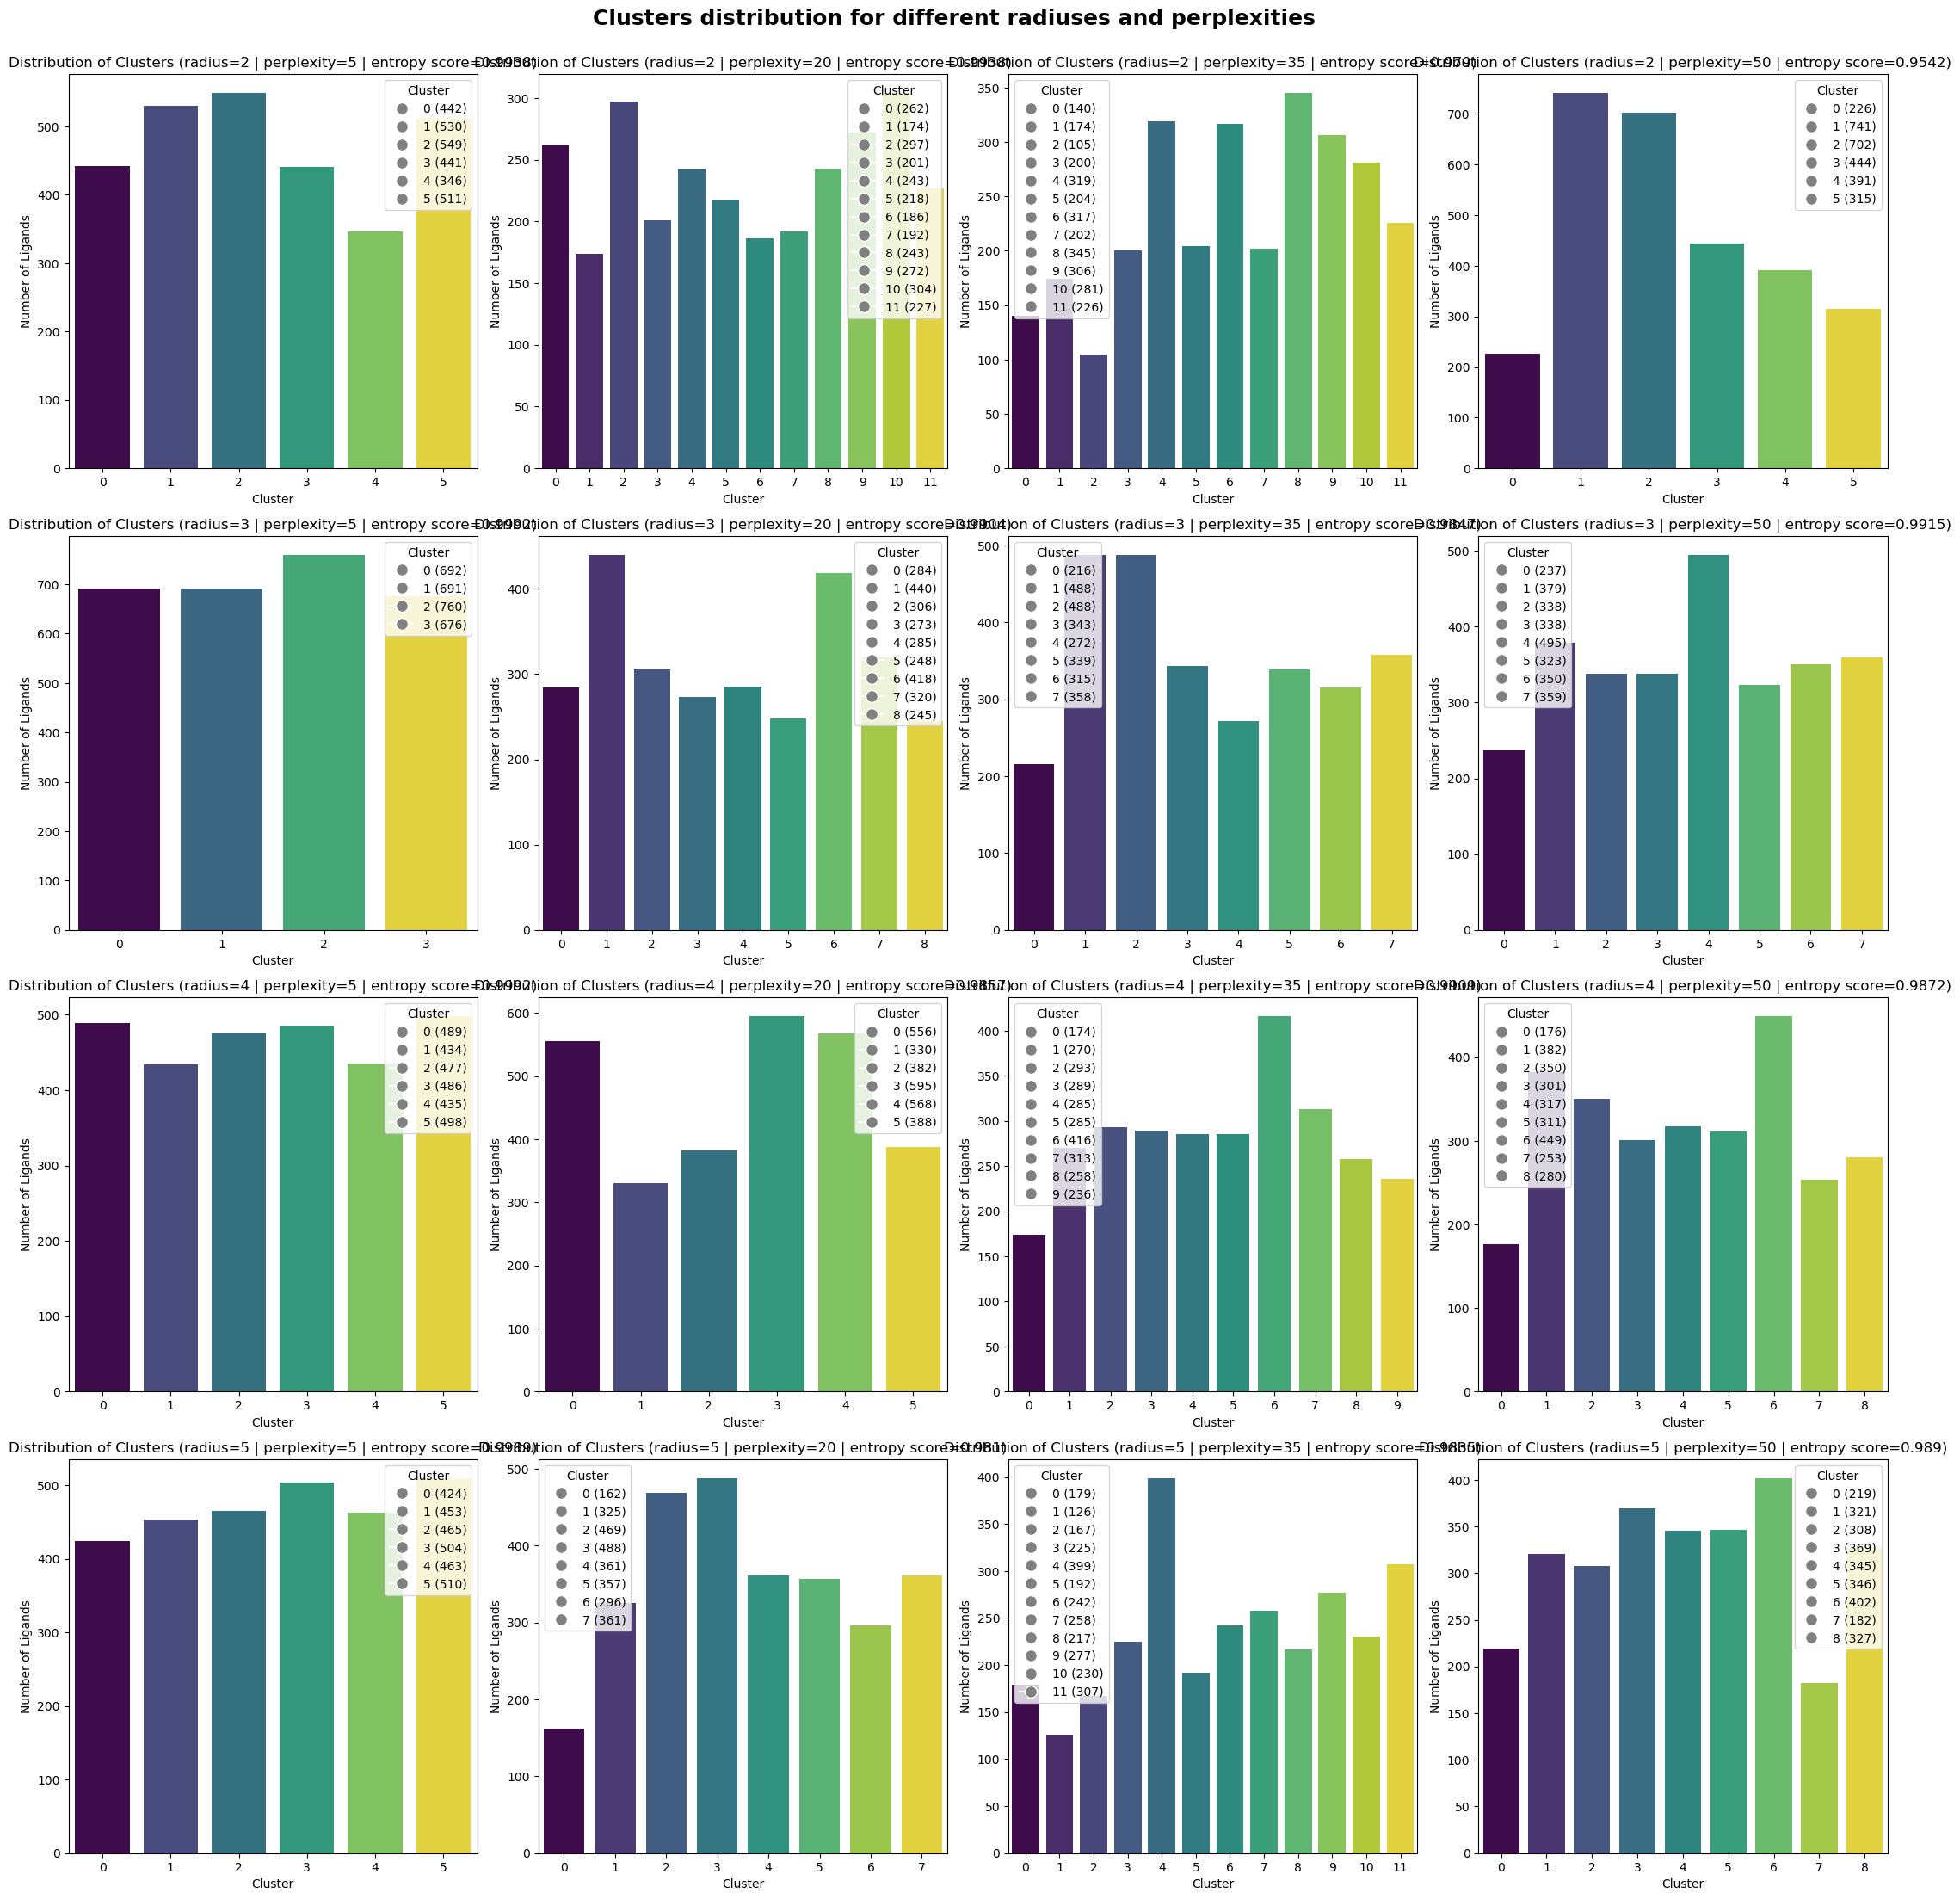

In [ ]:
plot_cluster_distributions(
    results=tsn_results, best_ks=best_ks, param1_values=radiuses, param2_values=perplexities,
    param1_name='radius', param2_name='perplexity',
    title="Clusters distribution for different radiuses and perplexities"
)

#### Choose best cluster according to KL metric and check them in reduced spatial representation ####

In [ ]:
# Choose best index based on KL
for idx_r in range(nrows):
    for idx_p in range(ncols):
        print(f'radius: {radiuses[idx_r]} | perplexity: {perplexities[idx_p]} | KL score: {KLs[idx_r][idx_p]}')

min_index_flat = np.argmin(KLs)
min_index = np.unravel_index(min_index_flat, KLs.shape)
k = best_ks[min_index[0]][min_index[1]]

radius: 2 | perplexity: 5 | KL score: 0.5613718032836914
radius: 2 | perplexity: 20 | KL score: 0.5116504430770874
radius: 2 | perplexity: 35 | KL score: 0.5049332976341248
radius: 2 | perplexity: 50 | KL score: 0.4930573105812073
radius: 3 | perplexity: 5 | KL score: 0.5668769478797913
radius: 3 | perplexity: 20 | KL score: 0.5250749588012695
radius: 3 | perplexity: 35 | KL score: 0.5210806727409363
radius: 3 | perplexity: 50 | KL score: 0.5242923498153687
radius: 4 | perplexity: 5 | KL score: 0.5631123185157776
radius: 4 | perplexity: 20 | KL score: 0.5208603143692017
radius: 4 | perplexity: 35 | KL score: 0.531927764415741
radius: 4 | perplexity: 50 | KL score: 0.5496487617492676
radius: 5 | perplexity: 5 | KL score: 0.5546144247055054
radius: 5 | perplexity: 20 | KL score: 0.5322427153587341
radius: 5 | perplexity: 35 | KL score: 0.5545495748519897
radius: 5 | perplexity: 50 | KL score: 0.5746510028839111


In [ ]:
TSNE_df = plot_3d_clusters(tsn_results, min_index, k, method_name='TSNE')

In [ ]:
smiles_cluster_MFG = pd.DataFrame(smiles_list)
smiles_cluster_MFG[f'Cluster'] = 0
for cluster in range(k):
    smiles_cluster_MFG[f'Cluster'] += ((TSNE_df['Cluster'] == cluster)*(cluster+1))
smiles_cluster_MFG.columns = ['Ligand SMILES', 'Cluster']
smiles_cluster_MFG.sample(10)

Ligand SMILES  Cluster
1690  CC(=O)c1cccc(CN2[C@H](Cc3ccccc3)[C@H](O)[C@@H]...        3
11    O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...        3
2197  CC[C@H](C)[C@H](NC(=O)C1CCCN1C[C@@H](O)[C@H](C...        4
131   O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(Cc2cccc(c2...        3
2518  O=C1[C@@H](CCc2ccccc2)N(Cc2ccccc2)C(=O)N(Cc2cc...        3
307   CCCC[C@@H]1NC(=O)[C@H](CCCCOc2ccc(C[C@H](NC1=O...        4
331   CC(C)[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](Cc1cc...        4
2078  Cn1ccnc1S(=O)(=O)Nc1cccc(c1)C(C1CC1)c1c(O)cc(o...        6
1088  COc1cccc(CN(Cc2ccc3OCOc3c2)C(=S)NCCCC[C@@H](CO...        1
1717  O[C@@H]1[C@@H](O)[C@@H](Cc2ccc(OCCN3CCOCC3)cc2...        3

## <b>Clustering with BERT Embeddings:</b> ##

#### Generating embeddings ####

In [ ]:
model_name = "seyonec/ChemBERTa-zinc-base-v1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [ ]:
embeddings = np.zeros((len(smiles_list), 768))

for i in range(len(smiles_list)):
  inputs = tokenizer(smiles_list[i], padding=True, truncation=True, return_tensors="pt")
  with torch.no_grad():
    outputs = model(**inputs)
  if i % 100 == 0:
    print(f'iterations {i}')
  embeddings[i] = outputs.last_hidden_state.mean(dim=1).numpy()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800


#### Using UMAP to reduce dimensions ####

N_neighbors = 15
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6
N_neighbors = 25
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6
N_neighbors = 50
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6
N_neighbors = 100
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6


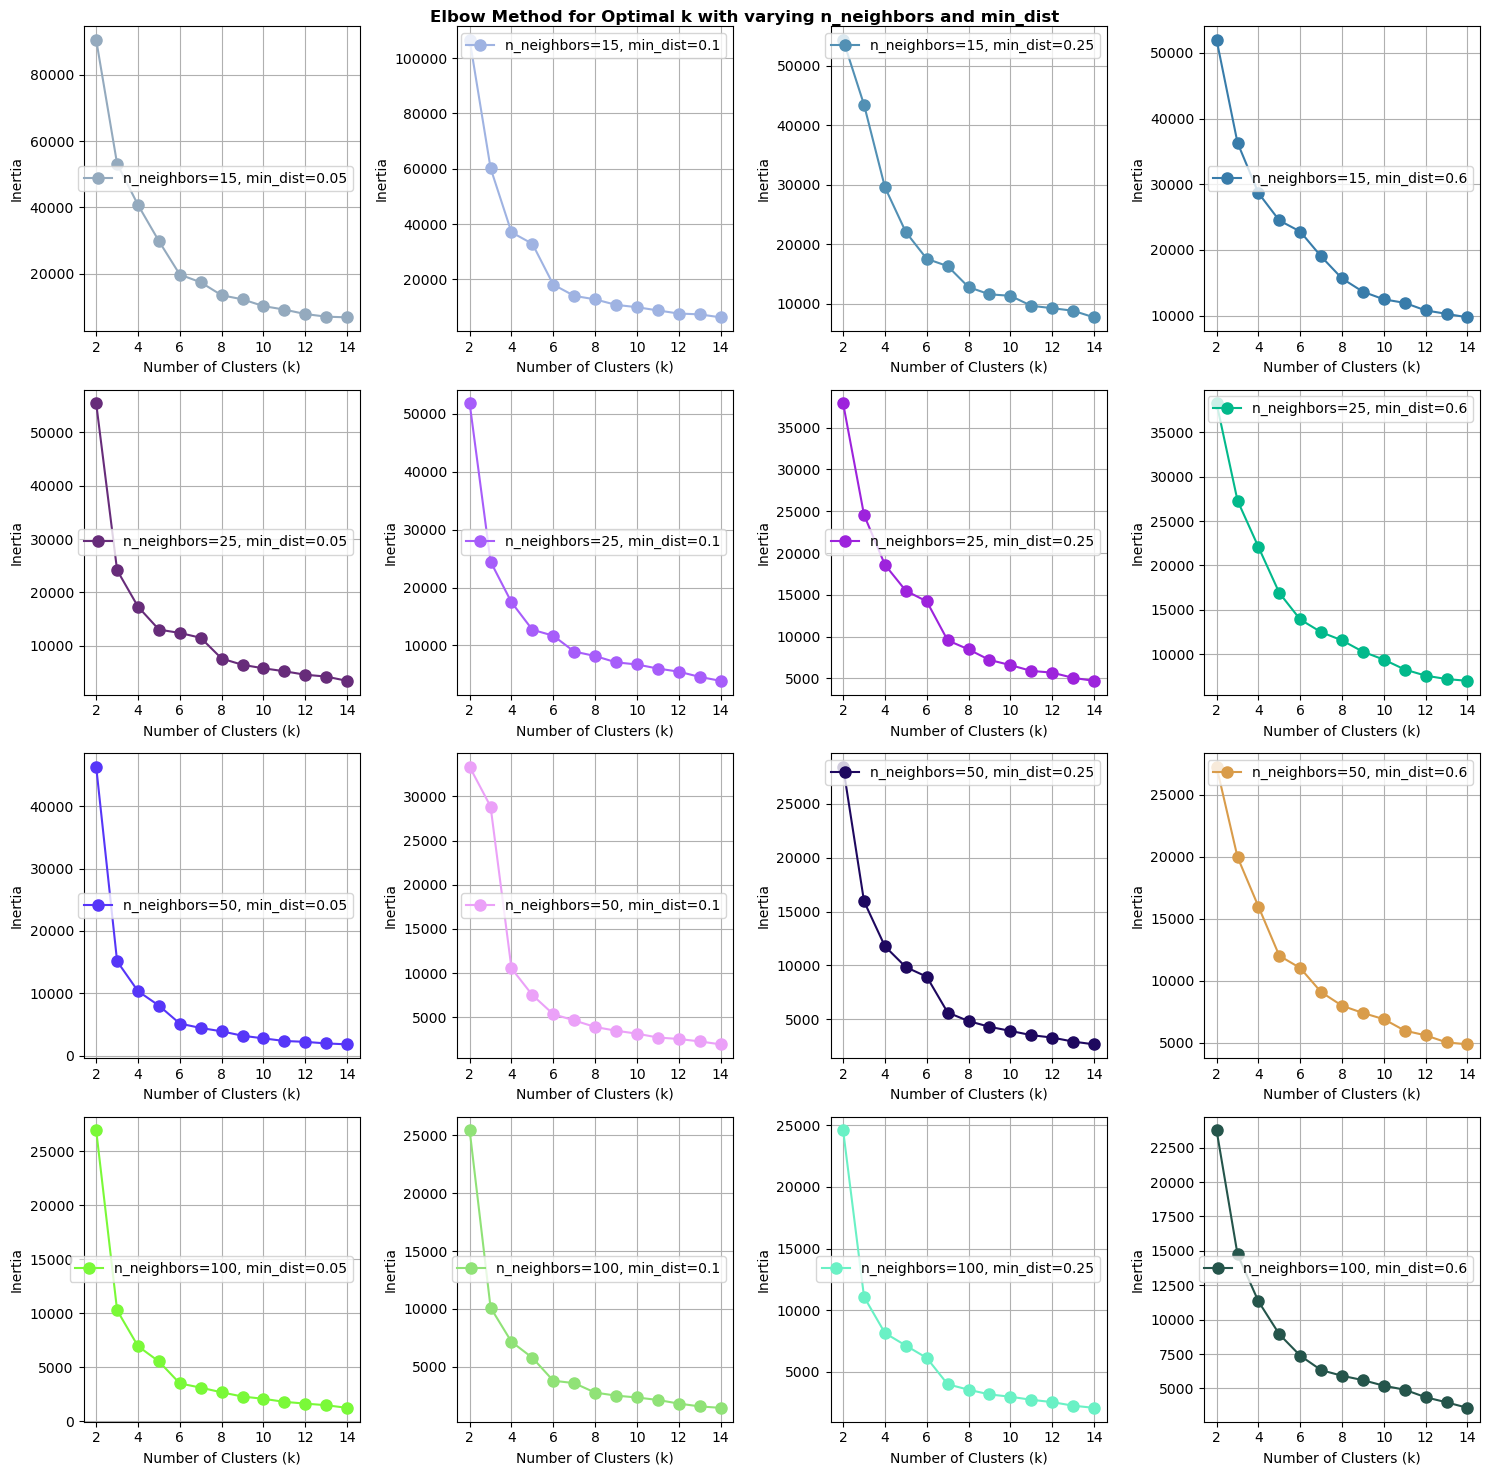

In [ ]:
l_n_neighbors = [15,25,50,100]
min_dists = [0.05,0.1,0.25,0.6]
nrows, ncols = len(l_n_neighbors), len(min_dists)
Ks = range(2, 15)

umap_results, trust_scores, s_scores = plot_elbow_curve(
                                                        method='umap',
                                                        original_data=embeddings,
                                                        param1_list=l_n_neighbors,
                                                        param2_list=min_dists,
                                                        Ks=Ks,
                                                        param1_name='n_neighbors',
                                                        param2_name='min_dist',
                                                        metric='cosine'
                                                        )

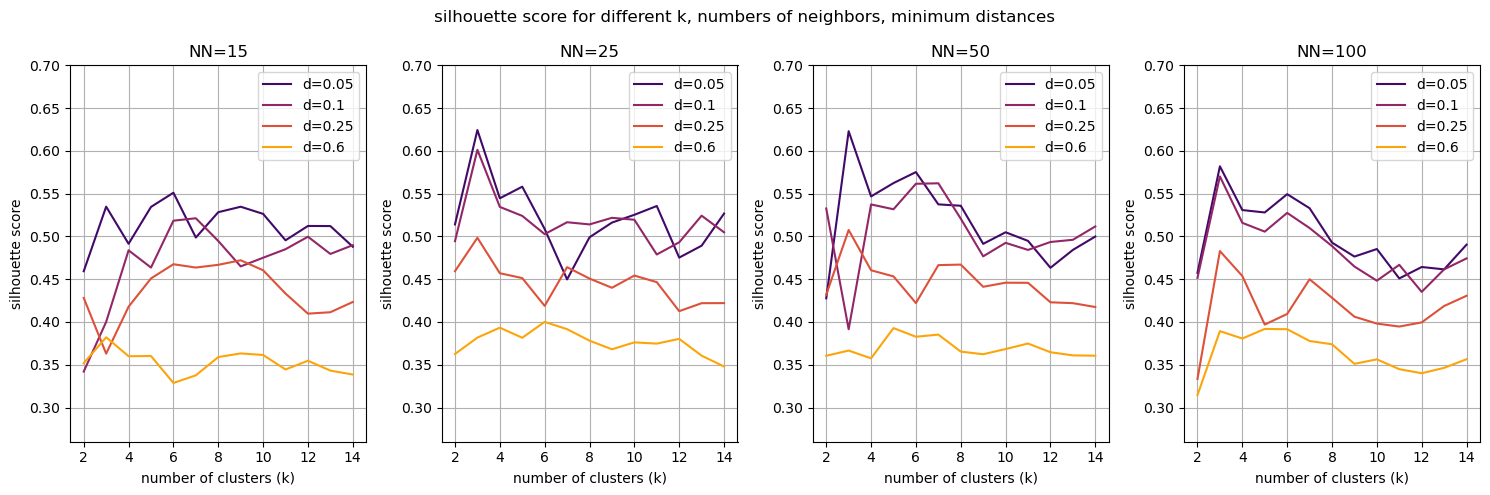

In [ ]:
plot_silhouette_scores(
    s_scores, Ks, l_n_neighbors, min_dists, 
    param1_name='NN', param2_name='d', y_lim=(0.26, 0.7),
    color_palette="inferno", title="silhouette score for different k, numbers of neighbors, minimum distances"
)

In [ ]:
# Choose best k for each radius and perplexity based on the graphes (not always clearly defined for some) (above 12 is excessive)
best_ks = [[6,3,2,3],
           [3,3,3,6],
           [3,6,3,6],
           [3,3,3,5]]

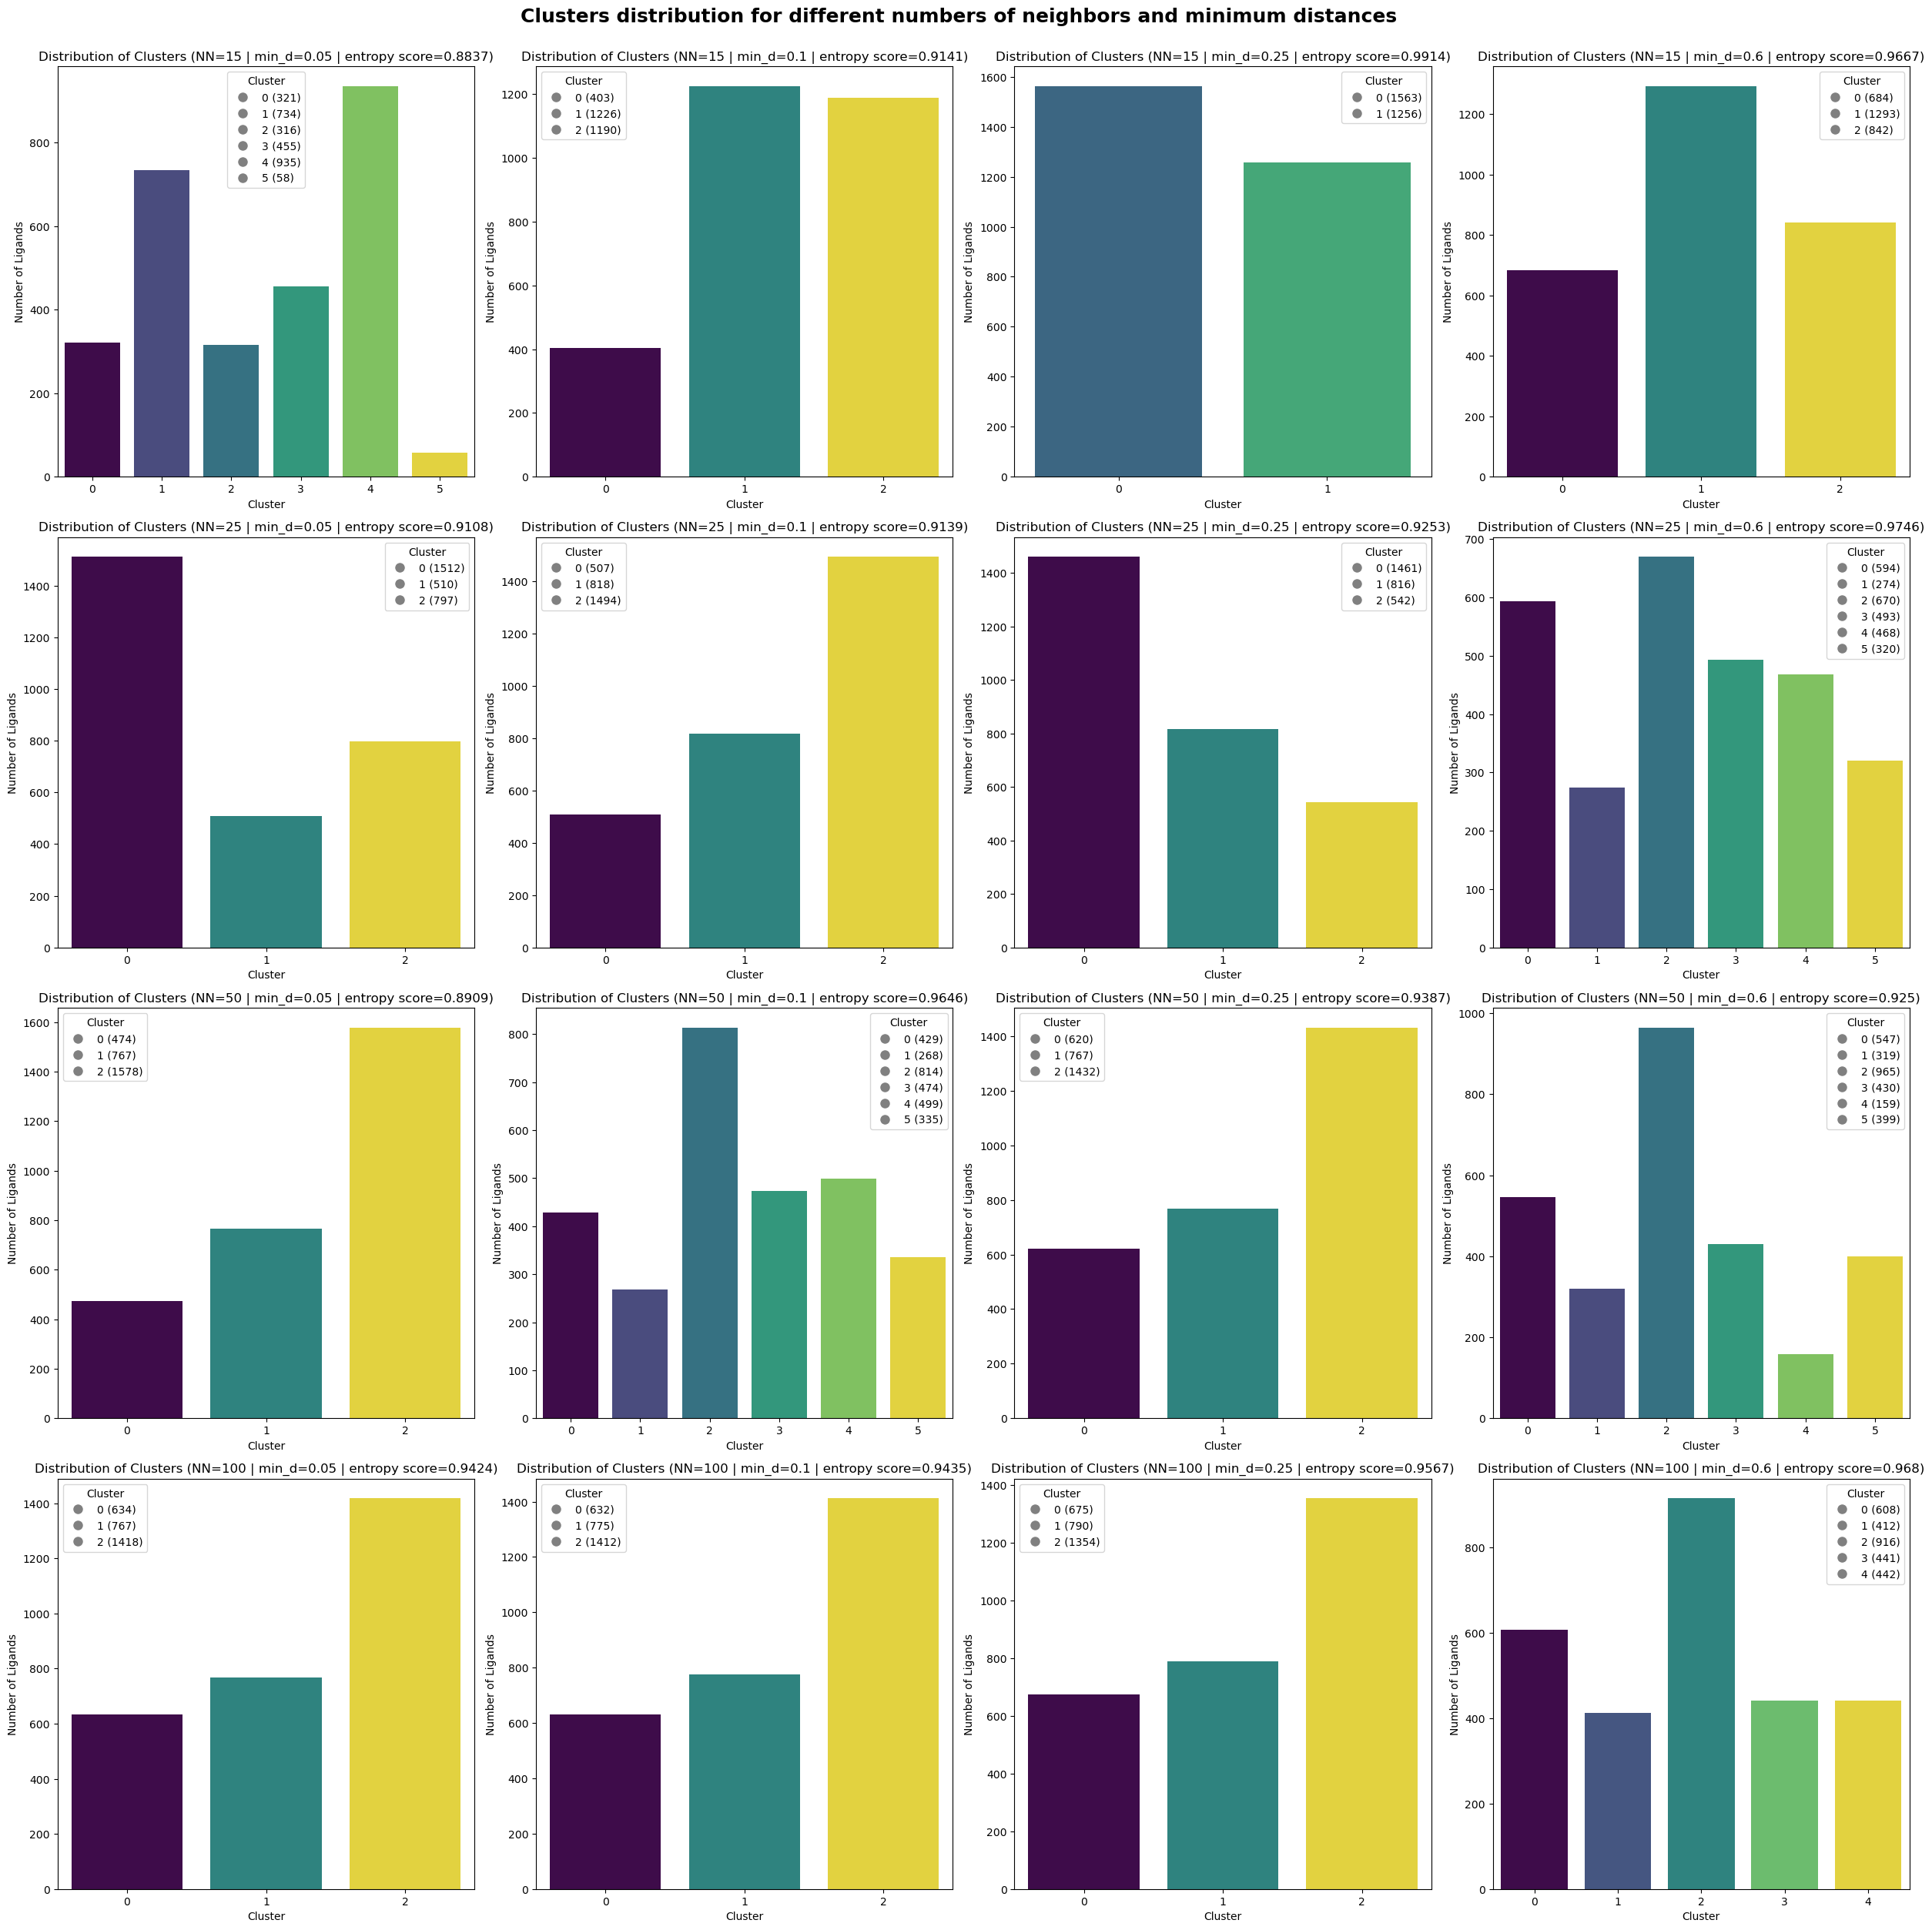

In [ ]:
plot_cluster_distributions(
    results=umap_results, best_ks=best_ks, param1_values=l_n_neighbors, param2_values=min_dists,
    param1_name='NN', param2_name='min_d', figsize=(25,25),
    title="Clusters distribution for different numbers of neighbors and minimum distances"
)

In [ ]:
# Choose best index based on KL
for idx_n in range(nrows):
    for idx_d in range(ncols):
        print(f'NN: {l_n_neighbors[idx_n]} | minimum distance: {min_dists[idx_d]} | trustworthiness score: {trust_scores[idx_r][idx_p]}')

min_index_flat = np.argmin(trust_scores)
min_index = np.unravel_index(min_index_flat, trust_scores.shape)
k = best_ks[min_index[0]][min_index[1]]
print(min_index)

NN: 15 | minimum distance: 0.05 | trustworthiness score: 0.9451984821804289
NN: 15 | minimum distance: 0.1 | trustworthiness score: 0.9451984821804289
NN: 15 | minimum distance: 0.25 | trustworthiness score: 0.9451984821804289
NN: 15 | minimum distance: 0.6 | trustworthiness score: 0.9451984821804289
NN: 25 | minimum distance: 0.05 | trustworthiness score: 0.9451984821804289
NN: 25 | minimum distance: 0.1 | trustworthiness score: 0.9451984821804289
NN: 25 | minimum distance: 0.25 | trustworthiness score: 0.9451984821804289
NN: 25 | minimum distance: 0.6 | trustworthiness score: 0.9451984821804289
NN: 50 | minimum distance: 0.05 | trustworthiness score: 0.9451984821804289
NN: 50 | minimum distance: 0.1 | trustworthiness score: 0.9451984821804289
NN: 50 | minimum distance: 0.25 | trustworthiness score: 0.9451984821804289
NN: 50 | minimum distance: 0.6 | trustworthiness score: 0.9451984821804289
NN: 100 | minimum distance: 0.05 | trustworthiness score: 0.9451984821804289
NN: 100 | minimum

In [ ]:
plot_3d_clusters(umap_results, (2,0), k, method_name='UMAP')

### NOT SURE TO USE THIS PART ###

In [ ]:
#Extract molecular weight, h-bond, ... from clusters

def extract_info_smiles(data, molecular_weights, h_bond_donors, h_bond_acceptors, xlim=2000):
    for smiles in data['Ligand SMILES']:
        try:
            mol = Chem.MolFromSmiles(smiles)  # Create RDKit molecule object
            if mol:
                # Calculate properties if SMILES is valid
                molecular_weights.append(Descriptors.MolWt(mol))
                h_bond_donors.append(Descriptors.NumHDonors(mol))
                h_bond_acceptors.append(Descriptors.NumHAcceptors(mol))
            else:
                # Add None if SMILES is invalid
                molecular_weights.append(None)
                h_bond_donors.append(None)
                h_bond_acceptors.append(None)
        except Exception as e:
            # Handle invalid SMILES error by appending None
            print(f"Error processing SMILES {smiles}: {e}")
            molecular_weights.append(None)
            h_bond_donors.append(None)
            h_bond_acceptors.append(None)

    # Add properties to DataFrame
    data['Molecular Weight'] = molecular_weights
    data['H-Bond Donors'] = h_bond_donors
    data['H-Bond Acceptors'] = h_bond_acceptors

    # Drop rows with any missing values in these new columns
    data.dropna(subset=['Molecular Weight', 'H-Bond Donors', 'H-Bond Acceptors'], inplace=True)

    metrics = ['Molecular Weight', 'H-Bond Donors', 'H-Bond Acceptors']

    for metric in metrics:
        plt.figure(figsize=(10, 6))
        sns.set(style="whitegrid")
        sns.histplot(data[metric], bins=30, color="skyblue")
        plt.title(f"Distribution of {metric} in HIV-Targeting Compounds")
        plt.xlabel(metric)
        plt.ylabel("Frequency")

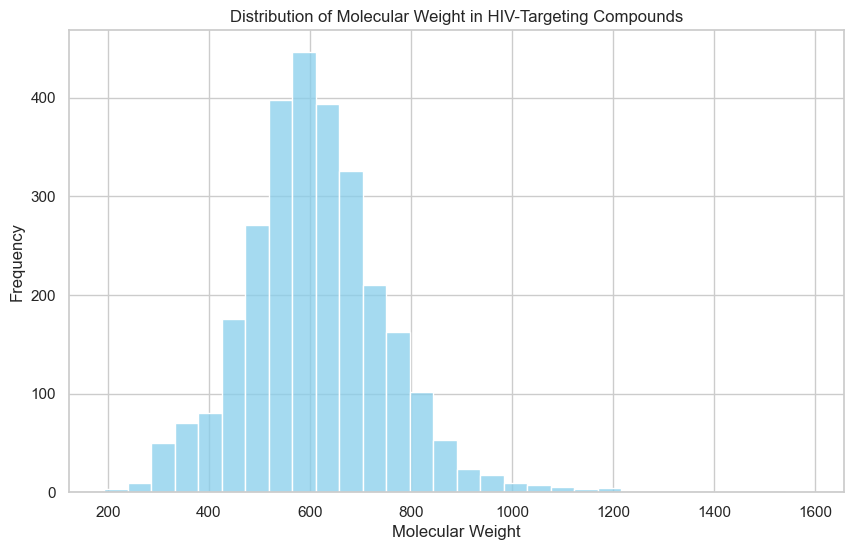

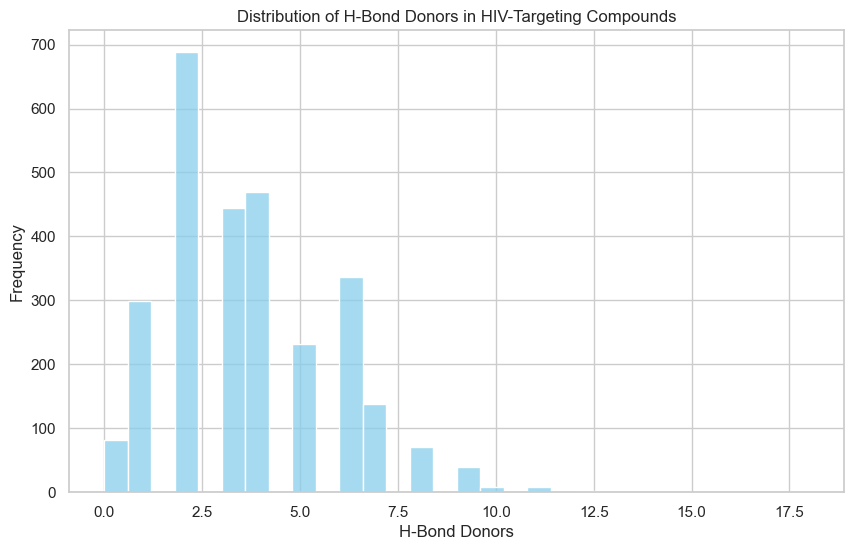

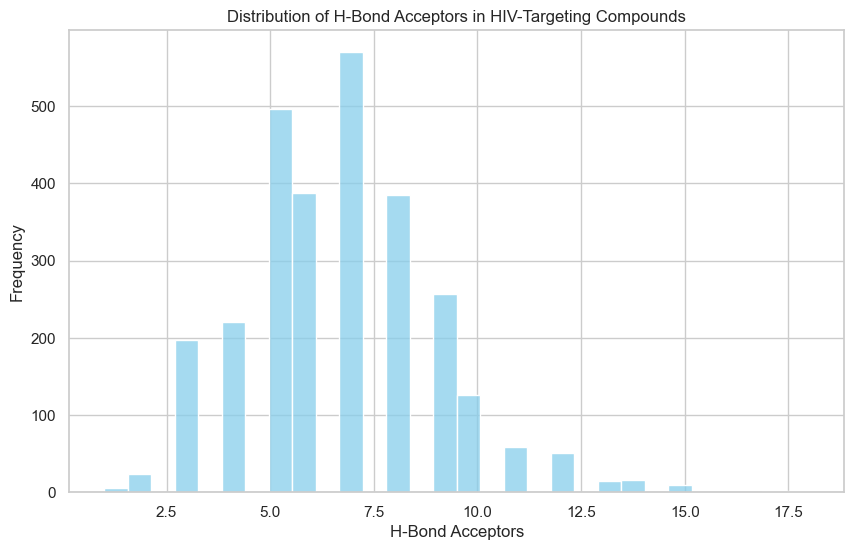

In [ ]:
molecular_weights = []
h_bond_donors = []
h_bond_acceptors = []
extract_info_smiles(smiles_cluster, molecular_weights, h_bond_donors, h_bond_acceptors, xlim=1500)